**Entropie**

In [17]:
import numpy as np
from collections import Counter
import math
import matplotlib.pyplot as plt


def entropie(vect):
    """
    Calcule l'entropie d'un vecteur
    """
    # On compte le nombre d'occurence de chaque valeur
    occurences = Counter(vect)
    # On calcule la probabilité de chaque valeur
    proba = [occurences[i]/len(vect) for i in occurences]
    # On calcule l'entropie
    entropie = -sum([p*math.log(p,2) for p in proba])
    return entropie

In [2]:
def entropie_cond(list_vect):
    """
    Calcule l'entropie conditionnelle d'une liste de vecteurs
    """
    # On calcule la taille de chaque vecteur
    taille_vect = [len(vect) for vect in list_vect]
    # On calcule la taille totale
    taille_totale = sum(taille_vect)
    # On calcule l'entropie conditionnelle
    entropie_cond = sum([taille_vect[i]/taille_totale*entropie(list_vect[i]) for i in range(len(list_vect))])
    return entropie_cond

In [3]:
import pickle
import numpy as np
# data : tableau ( films , features ) , id2titles : dictionnaire id -> titre ,
# fields : id feature -> nom
[data , id2titles, fields]= pickle.load(open("imdb_extrait.pkl" ,"rb" ))
# la derniere colonne est le vote
datax = data[:,:32]
datay = np.array([1 if x [33]>6.5 else -1 for x in data ])

In [4]:
liste = []
for i in range(28):
    liste.append(entropie(data[:,i]))
liste.append(entropie(datay))
print(liste)
print(fields[liste.index(max(liste))], max(liste))

[0.564976837274551, 0.7256620117131098, 0.7540946843905094, 0.2634038042219715, 0.1926285852674641, 0.9487805443246596, 0.2653268692430364, 0.5347013539632184, 0.040466328209344704, -0.0, -0.0, -0.0, 0.910475852461901, 0.13310901662996316, 0.4942546820981179, 0.00786173698629584, -0.0, 0.9999176833887986, 0.8103265236207233, 0.058438060605145864, 0.17702726334400468, 0.22865199105519707, 0.45026771320199777, 0.6915486835207777, 0.5144914462944487, -0.0, 0.19699814392010093, 0.3061179094676092, 0.986908946902129]
Drama 0.9999176833887986


**Quelques expériences préliminaires**

In [5]:
from sklearn.tree import export_graphviz
from sklearn.tree import DecisionTreeClassifier as DTree
import pydotplus

id2genre = [ x [1] for x in sorted ( fields . items ())[: -2]]
dt = DTree ()
dt . max_depth = 5 # on fixe la taille max de l ’ arbre a 5
dt . min_samples_split = 2 # nombre minimum d ’ exemples pour spliter un noeud
dt . fit ( datax , datay )
dt . predict ( datax [:5 ,:])
print ( dt.score(datax,datay))
# utiliser http :// www . webgraphviz . com / par exemple ou https :// dreampuf . github . io / Graphviz
export_graphviz ( dt , out_file = "/tmp/tree.dot " , feature_names = id2genre )
# ou avec pydotplus
tdot = export_graphviz ( dt , feature_names = id2genre )
pydotplus.graph_from_dot_data( tdot ). write_pdf ('tree . pdf')

0.736647045999564


True

In [6]:
id2genre = [ x [1] for x in sorted ( fields . items ())[: -2]]
for maxdepth in range(1, 10):
    
    dt = DTree ()
    dt . max_depth = maxdepth # on fixe la taille max de l ’ arbre a 5
    dt . min_samples_split = 2 # nombre minimum d ’ exemples pour spliter un noeud
    dt . fit ( datax , datay )
    dt . predict ( datax [:5 ,:])
    print ( dt.score(datax,datay))
    # utiliser http :// www . webgraphviz . com / par exemple ou https :// dreampuf . github . io / Graphviz
    export_graphviz ( dt , out_file = "/tmp/tree.dot " , feature_names = id2genre )
    # ou avec pydotplus
    tdot = export_graphviz ( dt , feature_names = id2genre )
    pydotplus.graph_from_dot_data( tdot ). write_pdf ('tree . pdf')

0.6418138216699367
0.6825812077610639
0.7183344233703945
0.7325049051667757
0.736647045999564
0.762589928057554
0.775888380204927
0.7996511881403968
0.8242860257248746


Le score de classification produit par la fonction score de scikit-learn n'est pas toujours un indicateur fiable du comportement d'un algorithme. Cela dépend en grande partie du jeu de données et des métriques de classification utilisées. Par exemple, le score de précision (precision) ne prend pas en compte les faux négatifs et peut donc être trompeur si les faux négatifs sont nombreux.

Pour obtenir un indicateur plus fiable du comportement de l'algorithme, il est souvent préférable d'utiliser plusieurs métriques de classification, telles que la précision, le rappel (recall), la matrice de confusion, l'aire sous la courbe ROC (AUC-ROC), etc.


**Sur et sous apprentissage**

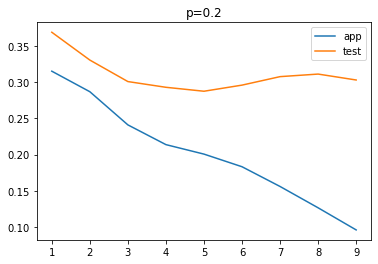

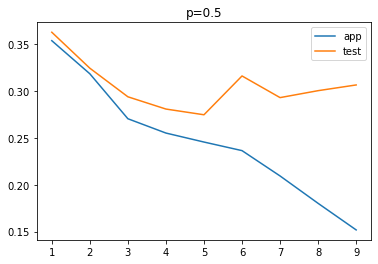

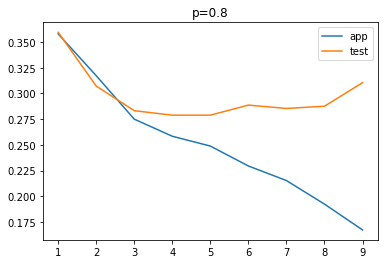

In [7]:
for p in [0.2,0.5,0.8]:
    l1 = []
    l2 = []
    for maxdepth in range(1,10):
        size = len(datax)
        train = datax[:int(p*size)]
        test = datax[int(p*size):]
        dt = DTree ()
        dt . max_depth = maxdepth # on fixe la taille max de l ’ arbre a 5
        dt . min_samples_split = 2 # nombre minimum d ’ exemples pour spliter un noeud
        dt . fit ( train , datay[:int(p*size)] )
        dt . predict (datax)
        # print ( "erreur en apprentissage", 1-dt.score(train,datay[:int(p*size)]))
        # print ( "erreur en test",1-dt.score(test,datay[int(p*size):]))
        l1.append(1-dt.score(train,datay[:int(p*size)]))
        l2.append(1-dt.score(test,datay[int(p*size):]))
    plt.plot(range(1,10), l1, label = 'app')
    plt.plot(range(1,10), l2, label ='test')
    plt.title('p='+str(p))
    plt.legend()
    plt.show()




**Validation croisée : sélection de modèle**

In [15]:
n = 10
size = len(datax)
erreur = []
for i in range(n):
    erreur_i = []
    train = datax[int(i*size/n): int((i+1)*size/n)]
    Y_train = datay[int(i*size/n): int((i+1)*size/n)]
    dt = DTree ()
    dt.max_depth = 5 # on fixe la taille /swapfilmax de l ’ arbre a 5
    dt.min_samples_split = 2 # nombre minimum d ’ exemples pour spliter un noeud
    dt.fit(train, Y_train)
    for j in range(n):
        if i!=j:
            test_j = datax[int(j*size/n): int((j+1)*size/n)]
            Y_test_j = datay[int(j*size/n): int((j+1)*size/n)]
            erreur_i.append(1-dt.score(test_j, Y_test_j))
    erreur.append(erreur_i)


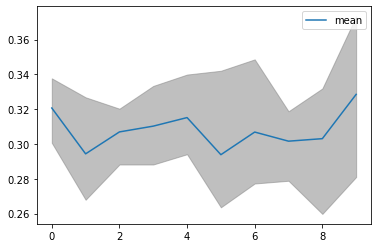

In [19]:
mean = np.mean(erreur, axis=1)
plt.plot(mean, label='mean')
plt.fill_between(range(len(mean)), np.min(erreur, axis=1), np.max(erreur, axis=1), color='gray', alpha=0.5)
plt.legend()
plt.show()

[0.32065362 0.29432854 0.30692316 0.31024399 0.31515784 0.29384122
 0.30684388 0.30160708 0.30305159 0.32850088]


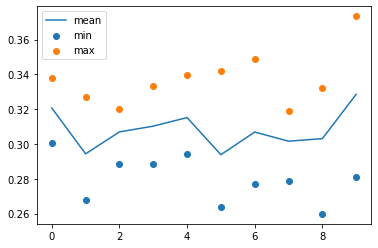

In [29]:
min_value = np.min(erreur, axis=1)
max_value = np.max(erreur, axis=1)
plt.plot(mean, label='mean')
print(mean)
plt.plot()
plt.plot(min_value[0], max_value[0],color= 'r')
plt.scatter(range(len(erreur)), min_value, label='min')
plt.scatter(range(len(erreur)), max_value, label='max')
plt.legend()
plt.show()

On peut voir que si on s'entraine $\frac{1}{10}$ des donnees, le modele ou i=1 minimise l'erreur.